In [26]:
from __future__ import division

In [1]:
from osgeo import gdal, ogr, gdalconst
import os
import subprocess as sp
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

In [2]:
def saveRaster(path, array, dsSource, datatype=3, formatraster="GTiff", nan=None): 
    """
    Datatypes:
    unknown = 0
    byte = 1
    unsigned int16 = 2
    signed int16 = 3
    unsigned int32 = 4
    signed int32 = 5
    float32 = 6
    float64 = 7
    complex int16 = 8
    complex int32 = 9
    complex float32 = 10
    complex float64 = 11
    float32 = 6, 
    signed int = 3
    
    Formatraster:
    GeoTIFF = GTiff
    Erdas = HFA (output = .img)
    OGC web map service = WMS
    png = PNG
    """
    # Set Driver
    format_ = formatraster #save as format
    driver = gdal.GetDriverByName( format_ )
    driver.Register()
    
    # Set Metadata for Raster output
    cols = dsSource.RasterXSize
    rows = dsSource.RasterYSize
    bands = dsSource.RasterCount
    datatype = datatype#band.DataType
    
    # Set Projection for Raster
    outDataset = driver.Create(path, cols, rows, bands, datatype)
    geoTransform = dsSource.GetGeoTransform()
    outDataset.SetGeoTransform(geoTransform)
    proj = dsSource.GetProjection()
    outDataset.SetProjection(proj)
    
    # Write output to band 1 of new Raster and write NaN value
    outBand = outDataset.GetRasterBand(1)
    if nan != None:
        outBand.SetNoDataValue(nan)
    outBand.WriteArray(array) #save input array
    #outBand.WriteArray(dem)
    
    # Close and finalise newly created Raster
    #F_M01 = None
    outBand = None
    proj = None
    geoTransform = None
    outDataset = None
    driver = None
    datatype = None
    bands = None
    rows = None
    cols = None
    driver = None
    array = None

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
def listall(RootFolder, varname='',extension='.png'):
    lists = [os.path.join(root, name)
             for root, dirs, files in os.walk(RootFolder)
             for name in files
             if varname in name
             if name.endswith(extension)]
    return lists

In [5]:
# get index from tif files
files_LST  = listall(r'J:\LST_recon', extension='.tif')
files_NDVI = listall(r'J:\NDVI_recon', extension='.tif')
#max_LST = r'J:\MAX_MIN_NDVI_recon_LST_recon//LST_recon_max_int.tif'
#min_LST = r'J:\MAX_MIN_NDVI_recon_LST_recon//LST_recon_min_int.tif'
max_NDVI = r'J:\MAX_MIN_NDVI_recon_LST_recon//NDVI_recon_max_int.tif'
min_NDVI = r'J:\MAX_MIN_NDVI_recon_LST_recon//NDVI_recon_min_int.tif'
alpha = 0.5

In [16]:
files_LST = files_LST[1095:-730]
files_NDVI = files_NDVI[1095:-730]

In [17]:
LST_dates = []
LST_doy_list = []
for LST in files_LST:
    #print LST
    LST_year = int(LST[-22:-18])
    LST_doy = int(LST[-7:-4])
    LST_date = datetime(LST_year, 1, 1) + timedelta(LST_doy - 1)
    LST_string = str(LST_date.year).zfill(2)+'-'+str(LST_date.month).zfill(2)+'-'+str(LST_date.day).zfill(2)
    #LST_date = np.datetime64(LST_date)
    #LST_date = pd.Timestamp(np.datetime_as_string(LST_date))    
    LST_dates.append(LST_date)
    LST_yday = LST_date.timetuple().tm_yday
    LST_doy_list.append(LST_yday)    

NDVI_dates = []
NDVI_doy_list = []
for NDVI in files_NDVI:
    #print NDVI
    NDVI_year = int(NDVI[-23:-19])
    NDVI_doy = int(NDVI[-7:-4])
    NDVI_date = datetime(NDVI_year, 1, 1) + timedelta(NDVI_doy - 1)
    NDVI_string = str(NDVI_date.year).zfill(2)+'-'+str(NDVI_date.month).zfill(2)+'-'+str(NDVI_date.day).zfill(2)    
    #NDVI_date = np.datetime64(NDVI_date)
    #NDVI_date = pd.Timestamp(np.datetime_as_string(NDVI_date))
    NDVI_dates.append(NDVI_date)
    NDVI_yday = NDVI_date.timetuple().tm_yday
    NDVI_doy_list.append(NDVI_yday)

In [ ]:
for idx, date in enumerate(LST_dates[2:365]):
    print date
    print 'LST'
    LST_in = LST_dates[idx]
    LST_single_doy_all_year = np.array(LST_dates)[np.array(LST_doy_list) == date.timetuple().tm_yday]
    
    # calculate maximum and minimum based on selection
    base_file = files_LST[LST_dates.index(LST_single_doy_all_year[0])]
    base_max = gdal.Open(base_file, gdalconst.GA_ReadOnly).ReadAsArray()
    base_min = gdal.Open(base_file, gdalconst.GA_ReadOnly).ReadAsArray()    
    for jdx, doy in enumerate(LST_single_doy_all_year):
        #print files_LST[LST_dates.index(doy)]
        ds = gdal.Open(files_LST[LST_dates.index(doy)], gdalconst.GA_ReadOnly).ReadAsArray()
        base_max = np.maximum.reduce([ds, base_max])
        base_min = np.minimum.reduce([ds, base_min])        
    # save max and min LST
    ds_base = gdal.Open(files_LST[LST_dates.index(doy)], gdalconst.GA_ReadOnly)
    date_of_year = str(date.timetuple().tm_yday).zfill(3)
    saveRaster(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST//LST_MAX_'+date_of_year+'.tif', 
               base_max, ds_base)
    saveRaster(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST//LST_MIN_'+date_of_year+'.tif', 
               base_min, ds_base)    
    
    print 'NDVI'    
    NDVI_in = NDVI_dates.index(date)
    NDVI_single_doy_all_year = np.array(NDVI_dates)[np.array(NDVI_doy_list) == date.timetuple().tm_yday]
    
    # calculate maximum and minimum based on selection
    base_file = files_NDVI[NDVI_dates.index(NDVI_single_doy_all_year[0])]
    base_max = gdal.Open(base_file, gdalconst.GA_ReadOnly).ReadAsArray()
    base_min = gdal.Open(base_file, gdalconst.GA_ReadOnly).ReadAsArray()    
    for jdx, doy in enumerate(NDVI_single_doy_all_year):
        #print files_NDVI[NDVI_dates.index(doy)]
        ds = gdal.Open(files_NDVI[NDVI_dates.index(doy)], gdalconst.GA_ReadOnly).ReadAsArray()
        base_max = np.maximum.reduce([ds, base_max])
        base_min = np.minimum.reduce([ds, base_min])         
    # save max and min LST
    ds_base = gdal.Open(files_NDVI[NDVI_dates.index(doy)], gdalconst.GA_ReadOnly)
    date_of_year = str(date.timetuple().tm_yday).zfill(3)
    saveRaster(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI//NDVI_MAX_'+date_of_year+'.tif', 
               base_max, ds_base)
    saveRaster(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI//NDVI_MIN_'+date_of_year+'.tif', 
               base_min, ds_base)        

In [ ]:
for idx, date in enumerate(LST_dates):
    print date
    print 'LST'
    LST_in = LST_dates[idx]
    LST_single_doy_all_year = np.array(LST_dates)[np.array(LST_doy_list) == date.timetuple().tm_yday]
    
    # calculate maximum and minimum based on selection
    base_file = files_LST[LST_dates.index(LST_single_doy_all_year[0])]
    base_mean = gdal.Open(base_file, gdalconst.GA_ReadOnly).ReadAsArray().astype(np.float64)
    base_mean = np.ma.masked_equal(base_mean,0)
    #print base_mean.max(), base_mean.min()
    #base_mean[np.ma.where( base_mean <= 0 )] = 0    
    base_mean -= base_mean
    for jdx, doy in enumerate(LST_single_doy_all_year):
        #print files_LST[LST_dates.index(doy)]
        ds = gdal.Open(files_LST[LST_dates.index(doy)], gdalconst.GA_ReadOnly).ReadAsArray().astype(np.float64)
        ds = np.ma.masked_equal(ds,0)
        #print ds.max(), ds.min()
        #ds[np.ma.where( ds <= 0 )] = 0
        base_mean += ds
        #print base_mean.max(), base_mean.min()        
        #base_max = np.maximum.reduce([ds, base_max])
        #base_min = np.minimum.reduce([ds, base_min])        
    # save max and min LST
    base_mean /= len(LST_single_doy_all_year)
    base_mean.fill_value = 0
    #base_mean *= 1000
    base_mean = np.rint(base_mean).astype(int)
    ds_base = gdal.Open(files_LST[LST_dates.index(doy)], gdalconst.GA_ReadOnly)
    date_of_year = str(date.timetuple().tm_yday).zfill(3)
    saveRaster(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST//LST_MEAN_'+date_of_year+'.tif', 
               base_mean, ds_base)
    #saveRaster(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST//LST_MIN_'+date_of_year+'.tif', 
    #           base_min, ds_base)    
    
    print 'NDVI'    
    NDVI_in = NDVI_dates.index(date)
    NDVI_single_doy_all_year = np.array(NDVI_dates)[np.array(NDVI_doy_list) == date.timetuple().tm_yday]
    
    # calculate maximum and minimum based on selection
    base_file = files_NDVI[NDVI_dates.index(NDVI_single_doy_all_year[0])]
    base_mean = gdal.Open(base_file, gdalconst.GA_ReadOnly).ReadAsArray().astype(np.float64)
    base_mean = np.ma.masked_equal(base_mean,-3000)
    base_mean[np.ma.where( base_mean <= 0 )] = 0
    base_mean -= base_mean   
    #base_mean = None
    for jdx, doy in enumerate(NDVI_single_doy_all_year):
        #print files_NDVI[NDVI_dates.index(doy)]
        ds = gdal.Open(files_NDVI[NDVI_dates.index(doy)], gdalconst.GA_ReadOnly).ReadAsArray().astype(np.float64)
        ds = np.ma.masked_equal(ds,-3000)
        ds[np.ma.where( ds <= 0 )] = 0
        base_mean += ds
        #base_max = np.maximum.reduce([ds, base_max])
        #base_min = np.minimum.reduce([ds, base_min])         
    # save max and min LST
    ds_base = gdal.Open(files_NDVI[NDVI_dates.index(doy)], gdalconst.GA_ReadOnly)
    base_mean /= len(NDVI_single_doy_all_year)
    base_mean.fill_value = 0 
    base_mean = np.rint(base_mean).astype(int)    
    date_of_year = str(date.timetuple().tm_yday).zfill(3)
    #print r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI//NDVI_MEAN_'+date_of_year+'.tif'
    saveRaster(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI//NDVI_MEAN_'+date_of_year+'.tif', 
               base_mean, ds_base)
    #saveRaster(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI//NDVI_MIN_'+date_of_year+'.tif', 
    #           base_min, ds_base)        

In [18]:
LST_doy_min = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST', varname='MIN', extension='.tif'))
LST_doy_max = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST', varname='MAX', extension='.tif'))
LST_doy_mean = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST', varname='MEAN', extension='.tif'))
NDVI_doy_min = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI', varname='MIN', extension='.tif'))
NDVI_doy_max = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI', varname='MAX', extension='.tif'))
NDVI_doy_mean = np.array(listall(r'J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI', varname='MEAN', extension='.tif'))

In [ ]:
# RECALCULATE VCI, TCI, VHI, NVAI, NTAI

In [30]:
for idx, LST_file in enumerate(files_LST): #files_LST
    
    #idx = files_01_03_15.index(LST_file)
    #LST_in = LST_dates_01_03_15[idx]
    LST_in = LST_dates[idx]
    print 'LST'
    
    ds_base = gdal.Open(LST_file, gdalconst.GA_ReadOnly)
    LST = gdal.Open(LST_file, gdalconst.GA_ReadOnly).ReadAsArray()
    LST_mean = gdal.Open(LST_doy_mean[LST_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    LST_max = gdal.Open(LST_doy_max[LST_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    LST_min = gdal.Open(LST_doy_min[LST_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    print LST_in, LST_doy_mean[LST_in.timetuple().tm_yday - 1]

    print 'NDVI'    
    NDVI_index = NDVI_dates.index(LST_in)
    NDVI_in = NDVI_dates[NDVI_index]
    NDVI = gdal.Open(files_NDVI[NDVI_index], gdalconst.GA_ReadOnly).ReadAsArray().astype(np.float64)
    #print NDVI_doy_mean[NDVI_in.timetuple().tm_yday - 1]
    NDVI_mean = gdal.Open(NDVI_doy_mean[NDVI_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    NDVI_max = gdal.Open(NDVI_doy_max[NDVI_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    NDVI_min = gdal.Open(NDVI_doy_min[NDVI_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    #print NDVI, NDVI_mean, NDVI_max, NDVI_min
    print files_NDVI[NDVI_index], NDVI_doy_mean[NDVI_in.timetuple().tm_yday - 1]
    
    print 'DI'
    VCI = (NDVI - NDVI_min) / (NDVI_max - NDVI_min)
    TCI = (LST_max - LST) / (LST_max - LST_min)
    VHI = (alpha * VCI) + (( 1 - alpha) * TCI)
    
    NVAI = (NDVI - NDVI_mean) / (NDVI_max - NDVI_min)
    NTAI = (LST - LST_mean) / (LST_max - LST_min)
    #NDAI = (alpha * NVAI - ( 1- alpha) * NTAI)
    
    fl_VCI = r'D:\Data\VCI_2003_2013//VCI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
    fl_TCI = r'D:\Data\TCI_2003_2013//TCI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
    fl_VHI = r'J:\VHI_2003_2013//VHI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
    fl_NVAI = r'D:\Data\NVAI_2003_2013//NVAI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
    fl_NTAI = r'D:\Data\NTAI_2003_2013//NTAI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
#     fl_NDAI = r'J:\NDAI_2003-2014//NDAI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
    print 'SAVING'
    saveRaster(fl_VCI, np.rint(VCI*1000), ds_base, 2)
    saveRaster(fl_TCI, np.rint(TCI*1000), ds_base, 2)
    saveRaster(fl_VHI, np.rint(VHI*1000), ds_base, 2)
    saveRaster(fl_NVAI, np.rint((NVAI+1)*1000), ds_base, 2)
    saveRaster(fl_NTAI, np.rint((NTAI+1)*1000), ds_base, 2)
#    saveRaster(fl_NDAI, np.rint((NDAI+1)*1000), ds_base, 2)
    #LST_single_doy_all_year = np.array(LST_dates)[np.array(LST_doy_list) == date.timetuple().tm_yday]
    #print LST_single_doy_all_year
    # calculate maximum and minimum based on selection
    #base_file = files_LST[LST_dates.index(LST_single_doy_all_year[0])]
    #print base_file
    #base_mean = gdal.Open(base_file, gdalconst.GA_ReadOnly).ReadAsArray()


LST
2003-01-01 00:00:00 J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST\LST_MEAN_001.tif
NDVI
J:\NDVI_recon\2003\CN_2003_NDVI_recon.001.tif J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI\NDVI_MEAN_001.tif
DI
SAVING
LST
2003-01-02 00:00:00 J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST\LST_MEAN_002.tif
NDVI
J:\NDVI_recon\2003\CN_2003_NDVI_recon.002.tif J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI\NDVI_MEAN_002.tif
DI
SAVING
LST
2003-01-03 00:00:00 J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST\LST_MEAN_003.tif
NDVI
J:\NDVI_recon\2003\CN_2003_NDVI_recon.003.tif J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI\NDVI_MEAN_003.tif
DI
SAVING
LST
2003-01-04 00:00:00 J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST\LST_MEAN_004.tif
NDVI
J:\NDVI_recon\2003\CN_2003_NDVI_recon.004.tif J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI\NDVI_MEAN_004.tif
DI
SAVING
LST
2003-01-05 00:00:00 J:\MAX_MIN_NDVI_recon_LST_recon\doy_LST\LST_MEAN_005.tif
NDVI
J:\NDVI_recon\2003\CN_2003_NDVI_recon.005.tif J:\MAX_MIN_NDVI_recon_LST_recon\doy_NDVI\NDVI_MEAN_005.tif
DI
SA

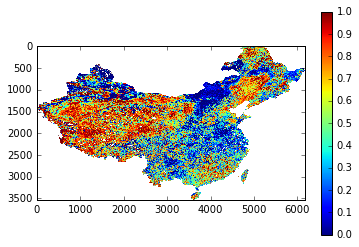

In [28]:
im = plt.imshow(VCI)
plt.colorbar(im)

In [29]:
alpha

0.5

In [ ]:
# CALCULATE NDAI 2000 - 2003 & 2015

In [ ]:
for idx, LST_file in enumerate(files_01_03_15): #files_LST
    
    idx = files_01_03_15.index(LST_file)
    LST_in = LST_dates_01_03_15[idx]
    #LST_in = LST_dates[idx]
    print 'LST'
    
    ds_base = gdal.Open(LST_file, gdalconst.GA_ReadOnly)
    LST = gdal.Open(LST_file, gdalconst.GA_ReadOnly).ReadAsArray()
    LST_mean = gdal.Open(LST_doy_mean[LST_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    LST_max = gdal.Open(LST_doy_max[LST_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    LST_min = gdal.Open(LST_doy_min[LST_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    print LST_in#, LST_doy_mean[LST_in.timetuple().tm_yday - 1]

    print 'NDVI'    
    NDVI_index = NDVI_dates.index(LST_in)
    NDVI_in = NDVI_dates[NDVI_index]
    NDVI = gdal.Open(files_NDVI[NDVI_index], gdalconst.GA_ReadOnly).ReadAsArray()
    #print NDVI_doy_mean[NDVI_in.timetuple().tm_yday - 1]
    NDVI_mean = gdal.Open(NDVI_doy_mean[NDVI_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    NDVI_max = gdal.Open(NDVI_doy_max[NDVI_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray()
    NDVI_min = gdal.Open(NDVI_doy_min[NDVI_in.timetuple().tm_yday - 1], gdalconst.GA_ReadOnly).ReadAsArray() 
    #print NDVI, NDVI_mean, NDVI_max, NDVI_min
    #print files_NDVI[NDVI_index], NDVI_doy_mean[NDVI_in.timetuple().tm_yday - 1]
    
    print 'DI'
#     VCI = (NDVI - NDVI_min) / (NDVI_max - NDVI_min)
#     TCI = (LST_max - LST) / (LST_max - LST_min)
#     VHI = (alpha * VCI + ( 1 - alpha) * TCI)
    
    NVAI = (NDVI - NDVI_mean) / (NDVI_max - NDVI_min)
    NTAI = (LST - LST_mean) / (LST_max - LST_min)
    NDAI = (alpha * NVAI - ( 1- alpha) * NTAI)
    
#     fl_VCI = r'D:\Data\VCI_2000_2015//VCI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
#     fl_TCI = r'D:\Data\TCI_2000_2015//TCI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
#     fl_VHI = r'J:\VHI_2000_2015//VHI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
#     fl_NVAI = r'D:\Data\NVAI_2000_2015//NVAI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
#     fl_NTAI = r'D:\Data\NTAI_2000_2015//NTAI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
    fl_NDAI = r'J:\NDAI_2003-2014//NDAI_'+str(LST_in.year)+'_'+str(LST_in.timetuple().tm_yday).zfill(3)+'.tif'
#     print 'SAVING'
#     saveRaster(fl_VCI, VCI, ds_base, 3)
#     saveRaster(fl_TCI, TCI, ds_base, 3)
#     saveRaster(fl_VHI, VHI, ds_base, 3)
#     saveRaster(fl_NVAI, NVAI, ds_base, 3)
#     saveRaster(fl_NTAI, NTAI, ds_base, 3)
    saveRaster(fl_NDAI, np.rint((NDAI+1)*1000), ds_base, 2)
    #LST_single_doy_all_year = np.array(LST_dates)[np.array(LST_doy_list) == date.timetuple().tm_yday]
    #print LST_single_doy_all_year
    # calculate maximum and minimum based on selection
    #base_file = files_LST[LST_dates.index(LST_single_doy_all_year[0])]
    #print base_file
    #base_mean = gdal.Open(base_file, gdalconst.GA_ReadOnly).ReadAsArray()


In [ ]:
im = plt.imshow(np.rint((NDAI+1)*1000), vmin=0, vmax=2000)
plt.colorbar(im)

In [ ]:
second = (NDVI_max-NDVI_min)

In [ ]:
im = plt.imshow(first)
plt.colorbar(im)

In [ ]:
5 - 6